In [119]:
import heapq,math,json,os,re,io,string,nltk,unicodedata,numpy as np,pandas as pd
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem import PorterStemmer
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
with open(r'C:\Users\Gabriele\Desktop\vocabulary.json', 'r') as fp:
    data = json.load(fp)
with open(r'C:\Users\Gabriele\Desktop\doc_ids.json', 'r') as fp:
    doc_ids = json.load(fp)
with open('index1.json', 'r') as fp:
    index = json.load(fp)
with open('json.json', 'r') as fp:
    url_title = json.load(fp)
with open('index2.json', 'r') as fp:
    index2 = json.load(fp)

In [17]:
def preprocessor_query(query):
    stop_words = set(stopwords.words('english'))
    line = query.lower()
    tokenizer  = RegexpTokenizer(r'\w+')
    ps = PorterStemmer()
    
    word = line.split()
    #removing stop words
    words = [w for w in word if not w in stop_words]
    #removing Punctuation from each word
    punct_remove = [" ".join(tokenizer.tokenize(w)) for w in words]
    #removing stem
    stemmed = [ps.stem(w) for w in punct_remove]
    #removing Accent
    accents = [unicodedata.normalize(u'NFKD', w).encode('ascii', 'ignore').decode('utf8') for w in stemmed]
    line = " ".join(accents)    
    
    string = ""
    string += line+"    "    
    
    return string.strip().split()

In [89]:
def search_engine_3():
    doc_bonus = []
    def conjunctive_query():
        my_query = input('Search Engine 3: Please enter your query:  ')             
        pre_query = preprocessor_query(my_query)

        set_docs = []

        for word in pre_query:
            if word in data.keys():
                id_term = str(data[word])

            if id_term in index.keys():
                set_docs.append(index[id_term])    ## index = inverted index

        for i in range(len(set_docs)):
            if i == 0:
                AND = set(set_docs[i])
            elif i == 1:
                second = set(set_docs[i])
                AND = AND.intersection(second)
            else:
                th = set(set_docs[i])
                AND = AND.intersection(th)

        return AND, url_title

    def score():
        AND, url_title = conjunctive_query()
        second_query = int(input('choose your preferred duration time: '))

        duration = {}
        minutes = []

        for i in AND:
            fi = open(r'C:\Users\Gabriele\Desktop\tsv\article-' + str(i) + '.tsv', encoding = 'utf8' )
            text = fi.read()
            fi.close()
            mins = []

            for j in range(13):
                mins.append(text[:text.find("\t")].strip())
                text = text[text.find("\t") + 1:]

            l = re.findall('\d+', mins[-3])
            if len(l) >= 1:
                score = abs(second_query - int(l[0]))
                minutes.append((score, i))
            else:
                minutes.append((500, i))
            if len(l) >= 1:  
                duration[str(i)] = int(l[0])
            else:
                duration[str(i)] = 'NA'
        # k = 15
        if len(AND) >= 15:
            sort_list = heapq.nsmallest(15, minutes)
        else:
            sort_list = heapq.nsmallest(len(AND), minutes)

        return sort_list, url_title, duration

    def dataframe_output():
        sort_list, url_title, duration = score()
        titles = []
        intros = []
        urls = []
        scores = []
        duration_time = []
        
        for i in sort_list:
            titles.append(url_title[str(i[1])]['Title'])
            intros.append(url_title[str(i[1])]['Intro'])
            urls.append(url_title[str(i[1])]['Url'])
            scores.append(i[0])
            duration_time.append(duration[str(i[1])])
            doc_bonus.append(str(i[1]))     
    dataframe_output()
    return doc_bonus    

# Search engine p3
here we used the search engine in part 3, modified the code, that in this case this function return the list of document_ids, that fits the users query. 

In [90]:
doc_id = search_engine_3()

Search Engine 3: Please enter your query:  batman joker
choose your preferred duration time: 80


In [91]:
doc_id

['16495', '11890', '8019', '17090', '11072', '14523', '15334']

# Opening Tsv
remember from the previous part we got the document_ids so we loop through every one of them and extarct from them the info of the actors, and we store them in a dictionary with this shape --> key:is the actors_name value is the list of doc_ids of films he/she has played.

In [98]:
def actors():
    actors = {}
    for i in doc_id[:9]:
        file = open(r"C:\Users\Gabriele\Desktop\tsv\article-" + str(i) + ".tsv", encoding = "utf8")
        file = file.read().split('\t')[7].split('\n')
       # file.pop(0)
       # file.pop()
        for actor in file:
            if actor not in actors.keys():
                actors[actor] = [i]
            else:
                actors[actor].append(i)
    return actors

In [99]:
ll = actors()
ll = dict(ll)

# Taking only the actors that had played in at least 2 movies

In [108]:
actors_dic = {}
for k, v in ll.items():
    if k == '"':
        continue
    elif len(v) >= 2:
        actors_dic[k] = v

for k,v in actors_dic.items():
    actors_dic[k] = set(v)
actors_dic 

{' Kevin Conroy ': {'11890', '16495'},
 ' Christian Bale ': {'14523', '15334'},
 ' Michael Caine ': {'14523', '15334'},
 ' Gary Oldman ': {'14523', '15334'},
 ' Morgan Freeman ': {'14523', '15334'}}

# We make intersection between previous results to get the connections.
if the length of the intersection is major or equal to 2 then there should be a connection. and we finally we store this edges in a list.

In [114]:
edges = []

for k, v in actors_dic.items():
    for i, j in actors_dic.items():
        if i != k:
            if len(v.intersection(j)) >= 2:
                edges.append((k, i))
edges             

[(' Christian Bale ', ' Michael Caine '),
 (' Christian Bale ', ' Gary Oldman '),
 (' Christian Bale ', ' Morgan Freeman '),
 (' Michael Caine ', ' Christian Bale '),
 (' Michael Caine ', ' Gary Oldman '),
 (' Michael Caine ', ' Morgan Freeman '),
 (' Gary Oldman ', ' Christian Bale '),
 (' Gary Oldman ', ' Michael Caine '),
 (' Gary Oldman ', ' Morgan Freeman '),
 (' Morgan Freeman ', ' Christian Bale '),
 (' Morgan Freeman ', ' Michael Caine '),
 (' Morgan Freeman ', ' Gary Oldman ')]

# Visualizing 
now we visualize every node and every connection.

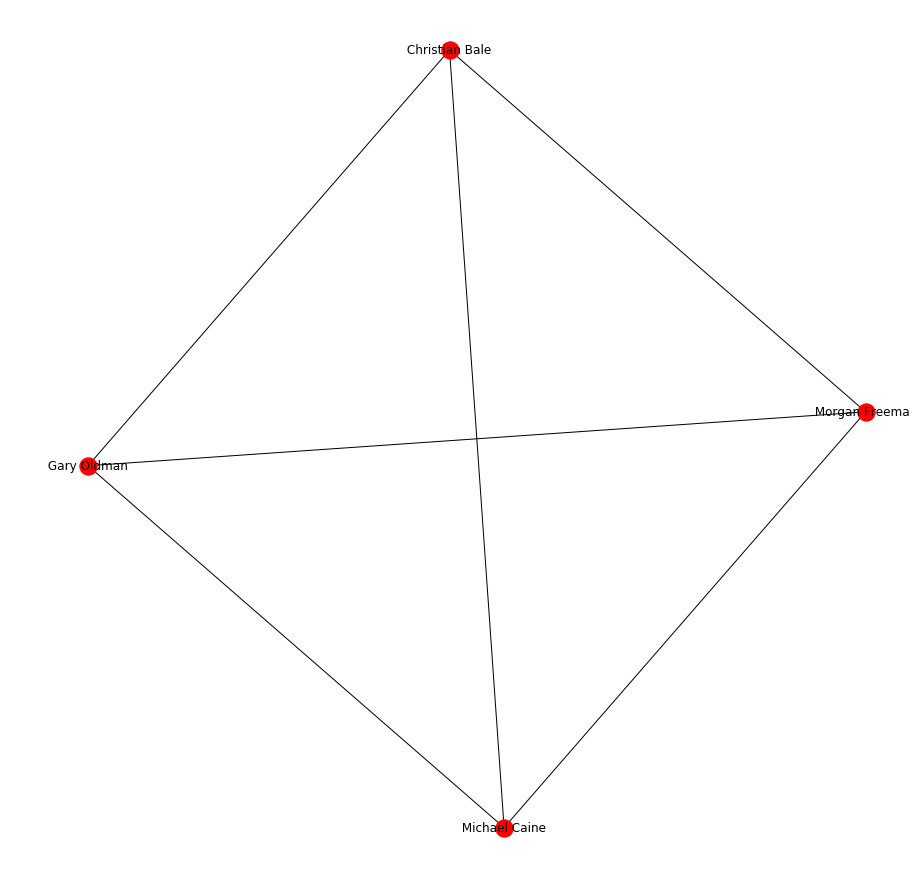

In [133]:
G = nx.Graph()
G.add_edges_from(edges)
# drawing part
plt.figure(figsize=(12,12))
nx.draw(G, with_labels = True, )
plt.draw()
plt.show()